# Basic GAN

This notebook shows a basic GAN setup. 64x64 images are created by a generator consisting of transpose convolution operations. The discriminator is a convolutional net. The networks are trained as a Wasserstein GAN, where discriminator weights are clipped to be within (-0.01, 0.01).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *
import matplotlib.animation as animation

In [3]:
path = Path('G:/Mars/image_patches/')

In [4]:
len(os.listdir(path))

664203

In [5]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs, num_workers=4)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [6]:
data = get_data(64, 128)

Example data, at 64x64 resolution

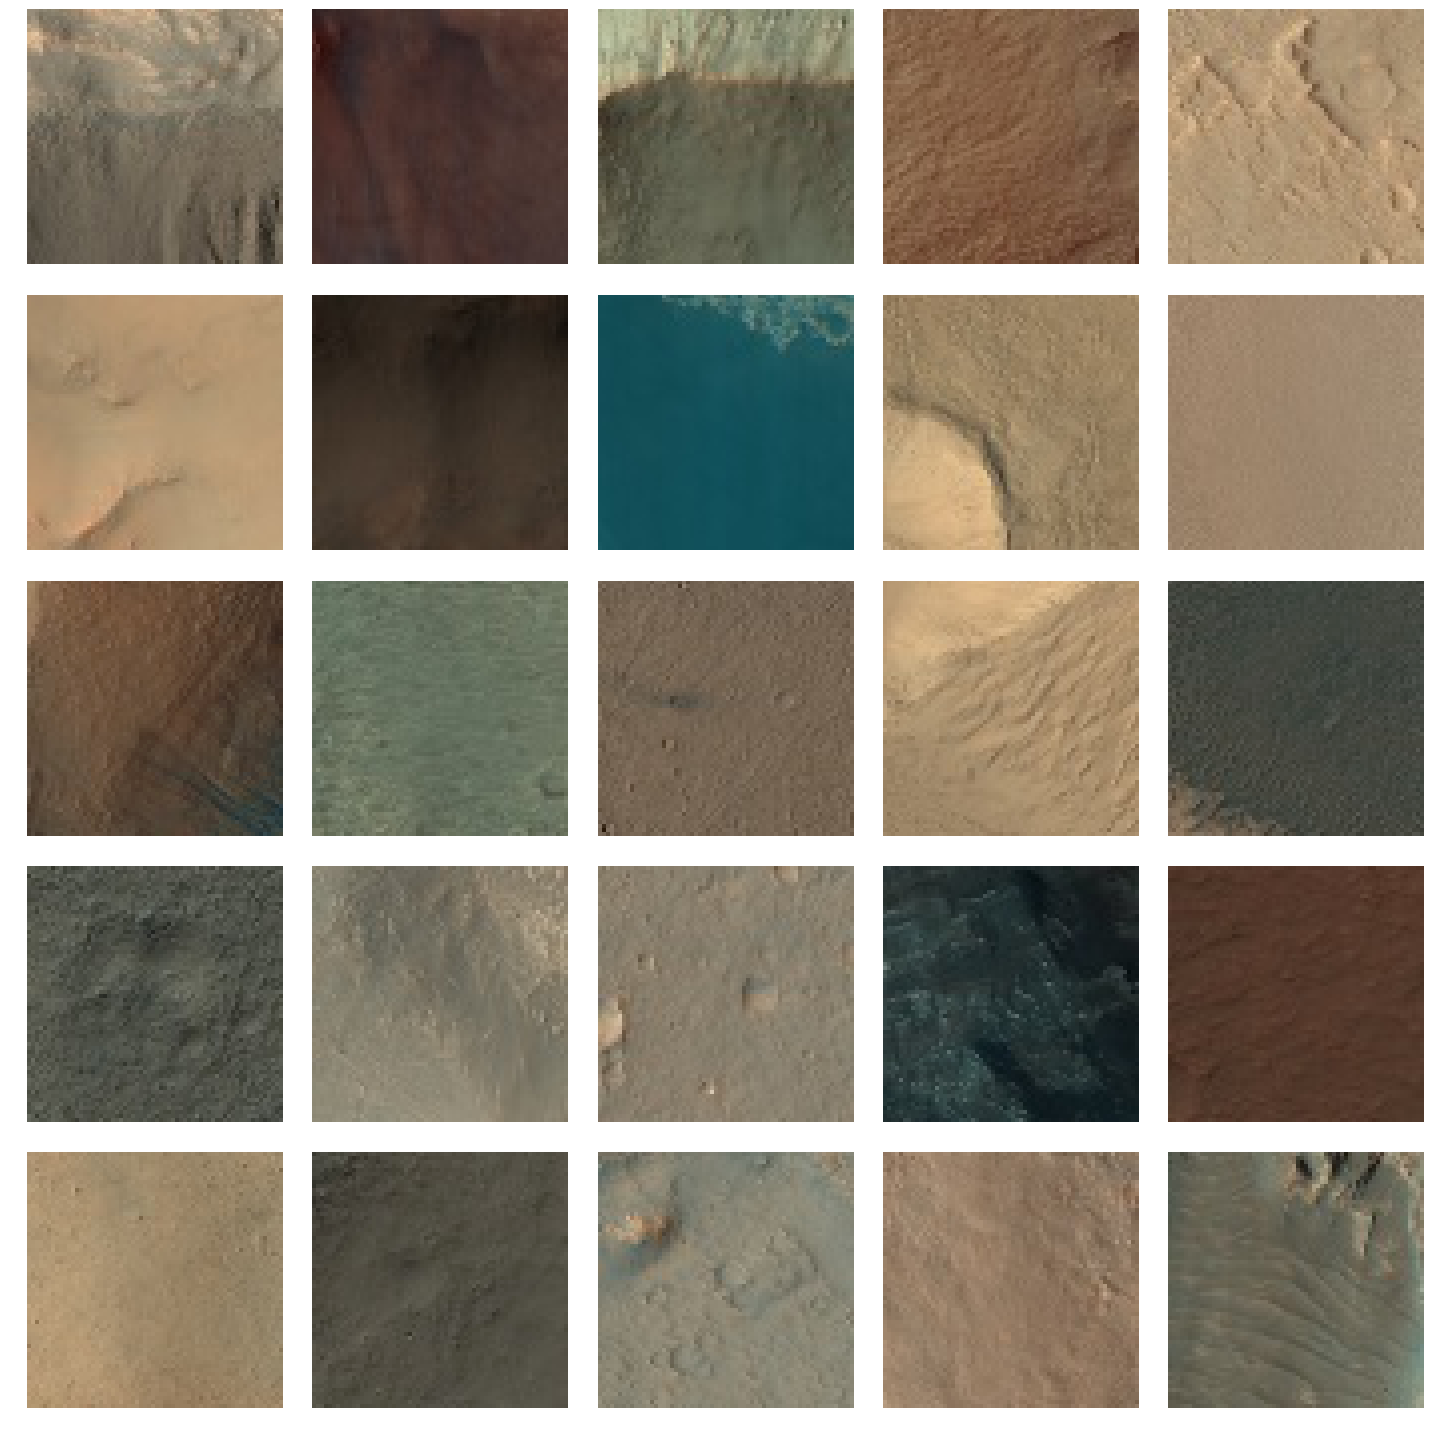

In [7]:
data.show_batch(rows=5)

In [7]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [8]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

The generator is a series of blocks containing:
 * Transposed Convolution
 * Relu
 * Batchnorm

Which upsample the input vector to a size of 32x32.

The final transposed convolution upscales the image to a resolution of 64x64, before putting the final image through a Tanh nonlinearity

In [9]:
generator

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3)

The critic follows a similar format of 
 * Convolution
 * Relu
 * Batchnorm
 
Blocks, before a final lambda layer that averages outputs across the batch.

In [10]:
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4),

Now for training. We train the critic for 5 iterations to every one training iteration of the generator, to ensure the critic is always overpowering the generator and forcing it to generate images more like the training dataset.

We optimize using Adam with $\beta_{1} = 0$ to disable momentum. Adversarial training creates very spikey movements in the loss output caused by the generator and the discriminator competing. This causes problems with momentum in optimization.

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-1.144015,#na#,0.713156,-1.518997,47:39
1,-1.127294,#na#,0.711854,-1.482985,48:38
2,-1.032366,#na#,0.704103,-1.395076,1:01:15
3,-0.524305,#na#,0.442777,-0.725155,53:21
4,-0.890769,#na#,0.506878,-1.150338,1:40:07
5,-0.915441,#na#,0.594663,-1.263137,54:32
6,-1.050178,#na#,0.710006,-1.396951,48:08
7,-0.491525,#na#,0.197077,-0.606427,50:16
8,-0.458104,#na#,0.294832,-0.625748,44:46
9,-0.524165,#na#,0.503499,-0.789811,42:45


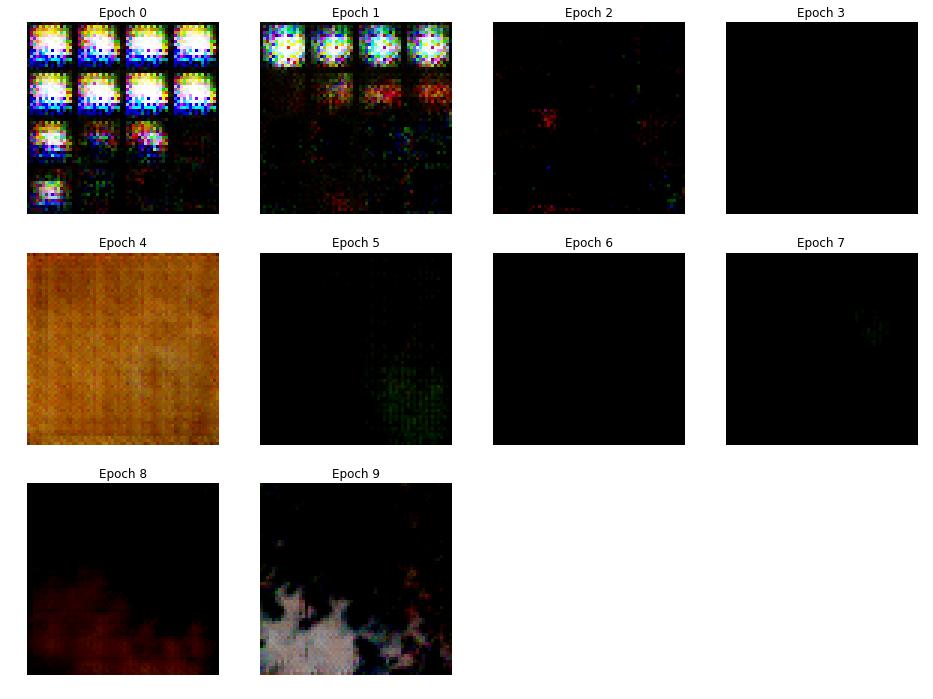

In [11]:
learn.fit(10, 2e-4)

After 10 epochs, the generator produces images that match the color and some textures of the training data, but there are still lots of artifacts in the images.

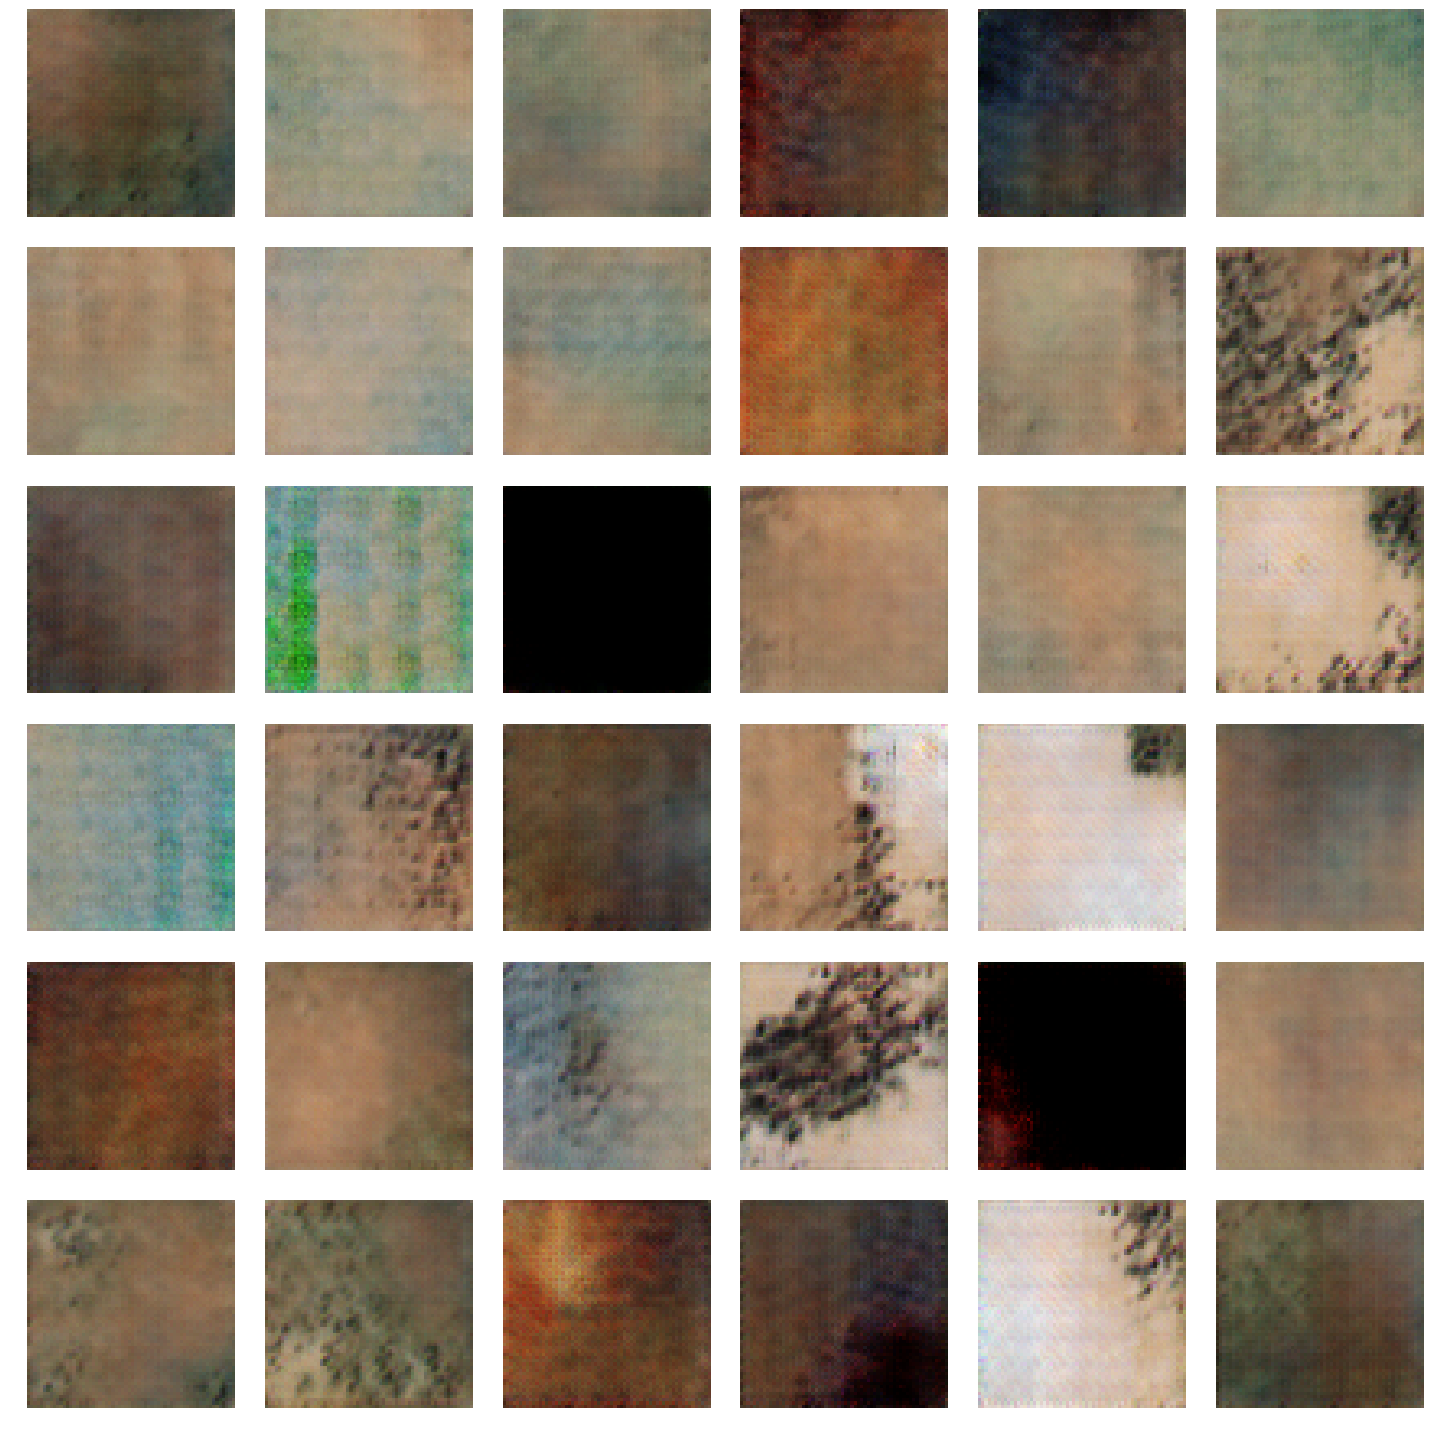

In [12]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=6, figsize=(20,20))

In [13]:
learn.save('mars1')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.493369,#na#,0.351150,-0.682537,44:15
1,-1.001152,#na#,0.691626,-1.297011,42:02
2,-1.072553,#na#,0.625868,-1.442305,41:55
3,-0.595463,#na#,0.407916,-0.784788,42:47
4,-0.586714,#na#,0.419054,-0.790131,45:34


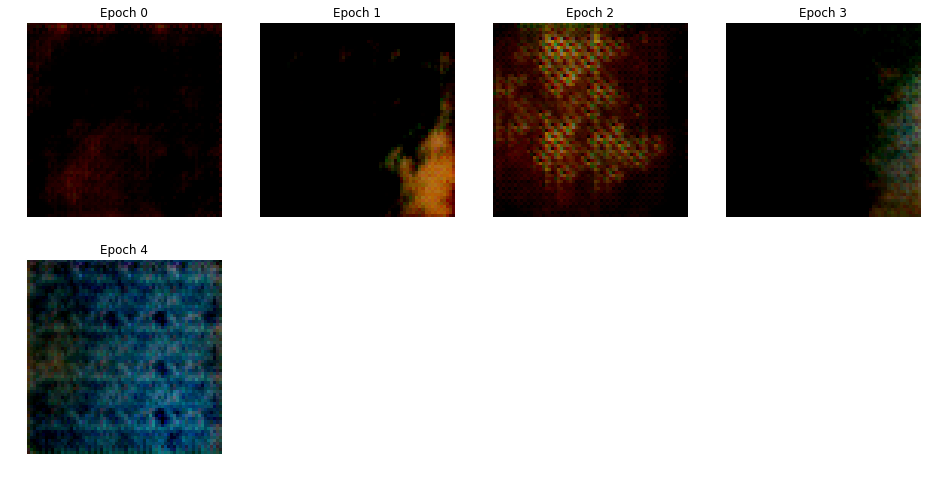

In [14]:
learn.fit(5, 2e-4)

In [15]:
learn.save('mars2')

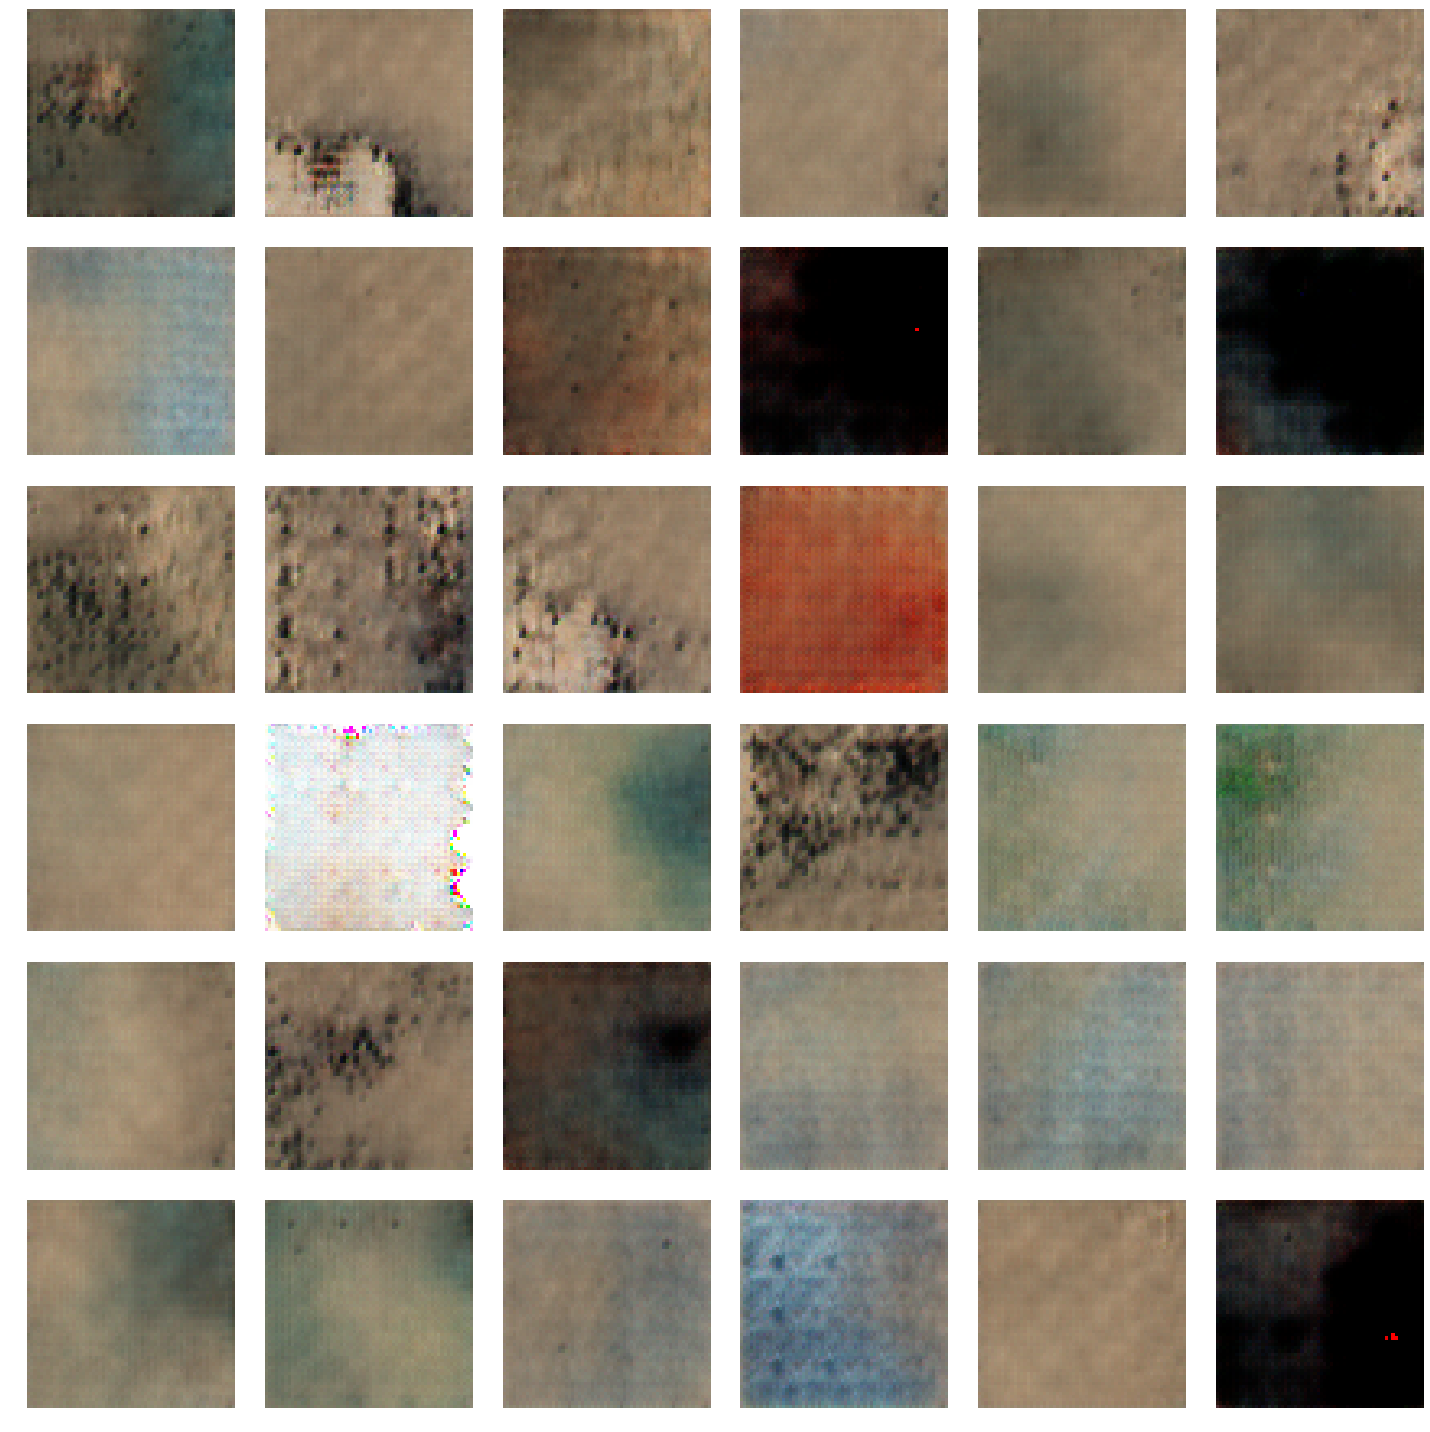

In [16]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=6, figsize=(20,20))

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.742083,#na#,0.525600,-0.998230,52:30
1,-0.628581,#na#,0.474505,-0.840469,46:18
2,-0.684936,#na#,0.537454,-0.946269,46:18
3,-0.480864,#na#,0.416801,-0.665132,45:03
4,-0.498961,#na#,0.412155,-0.689654,44:24
5,-0.487322,#na#,0.282945,-0.631633,43:24
6,-0.453231,#na#,0.341517,-0.620887,44:55
7,-0.435596,#na#,0.315037,-0.587344,49:07


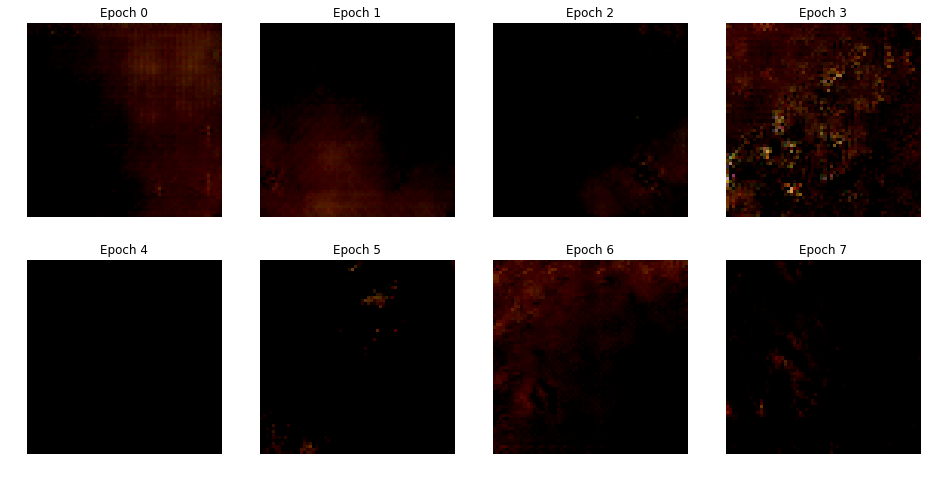

In [17]:
learn.fit(8, 2e-4)

In [18]:
learn.save('mars3')

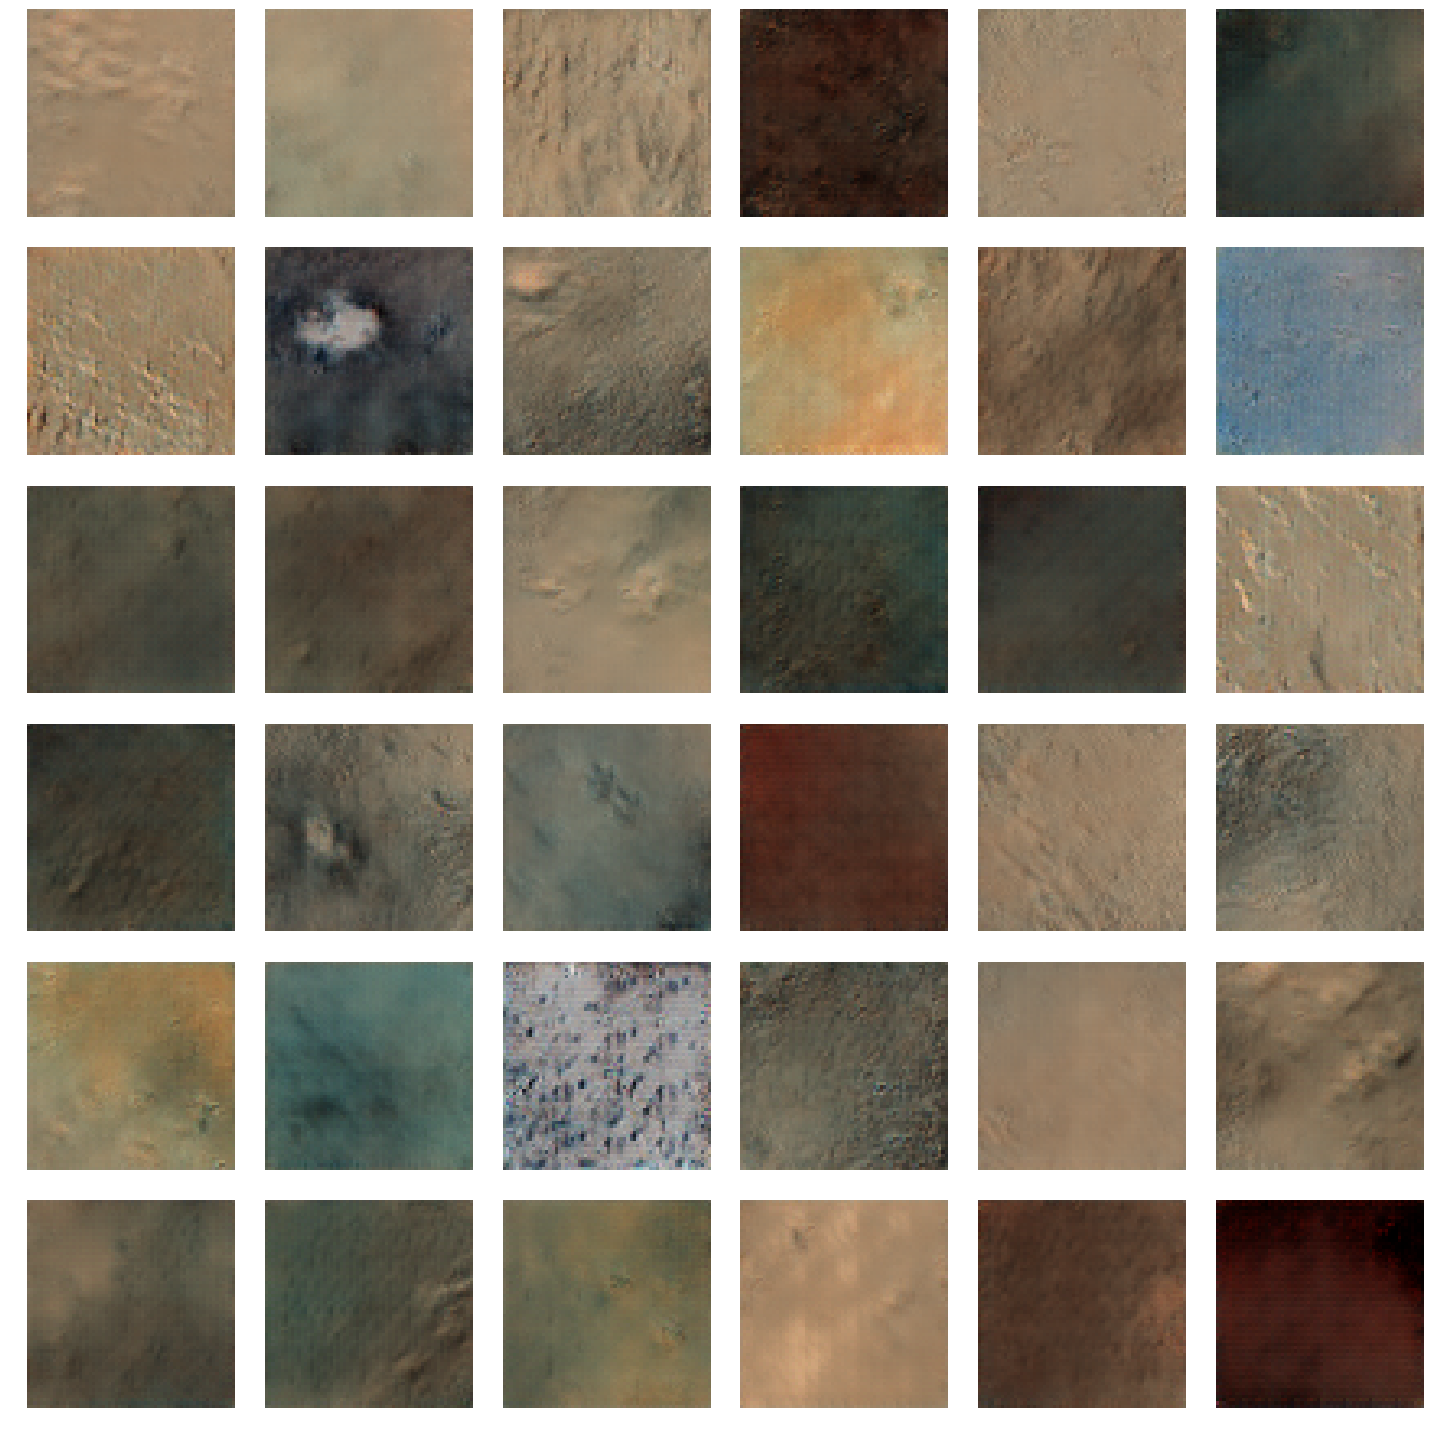

In [19]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=6, figsize=(20,20))

In [9]:
learn.load('mars3', purge=False);

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.368833,#na#,0.235643,-0.501748,56:09
1,-0.324179,#na#,0.160859,-0.422321,47:16
2,-0.234615,#na#,0.219303,-0.344192,47:39
3,-0.282176,#na#,0.128207,-0.365505,47:16
4,-0.200549,#na#,-0.017779,-0.240334,47:04
5,-0.142568,#na#,-0.011634,-0.190545,50:00
6,-0.269814,#na#,0.082208,-0.334058,1:07:40
7,-0.080529,#na#,0.074808,-0.118539,47:56
8,-0.174732,#na#,0.094517,-0.197680,49:22
9,0.010781,#na#,0.209428,-0.048293,48:44


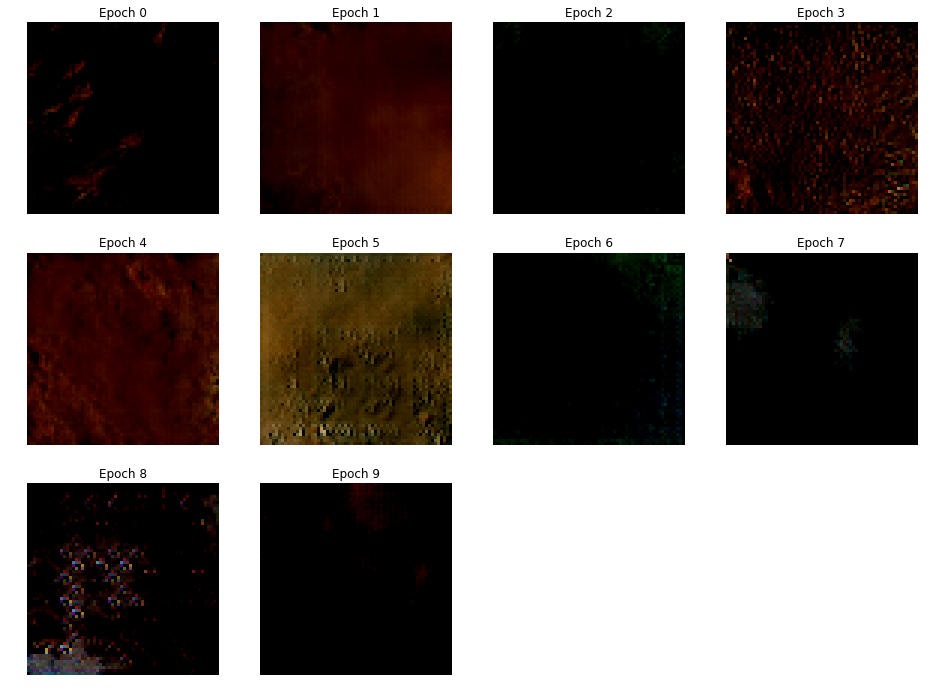

In [11]:
learn.fit(10, 2e-4)

In [12]:
learn.save('mars4')

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.079403,#na#,0.163160,-0.155750,48:53
1,-0.090722,#na#,0.123160,-0.141731,48:22
2,-0.077509,#na#,0.003400,-0.045112,50:23
3,-0.081235,#na#,-0.128101,-0.065583,51:57
4,-0.244716,#na#,0.217169,-0.339152,47:46
5,-0.245259,#na#,0.106519,-0.294544,48:23
6,-0.173177,#na#,0.132846,-0.236952,49:53
7,-0.178407,#na#,0.193885,-0.243502,49:14
8,-0.163241,#na#,0.142400,-0.252632,48:25
9,-0.178009,#na#,0.107992,-0.234743,48:34


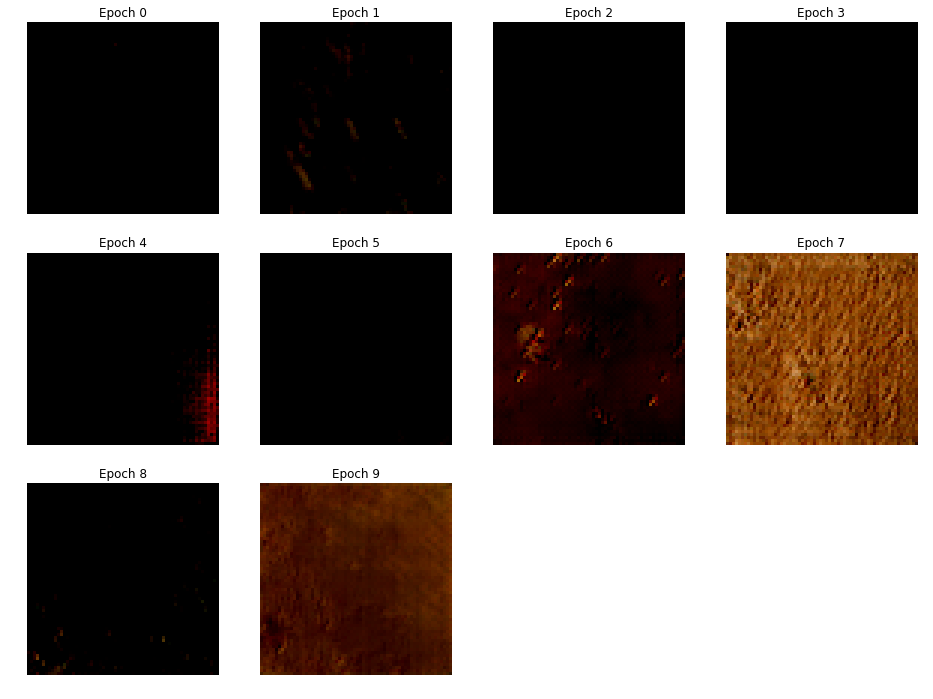

In [13]:
learn.fit(10, 2e-4)

In [14]:
learn.save('mars5')

After significantly more training, we produce smoother looking images with more realistic surface features and textures.

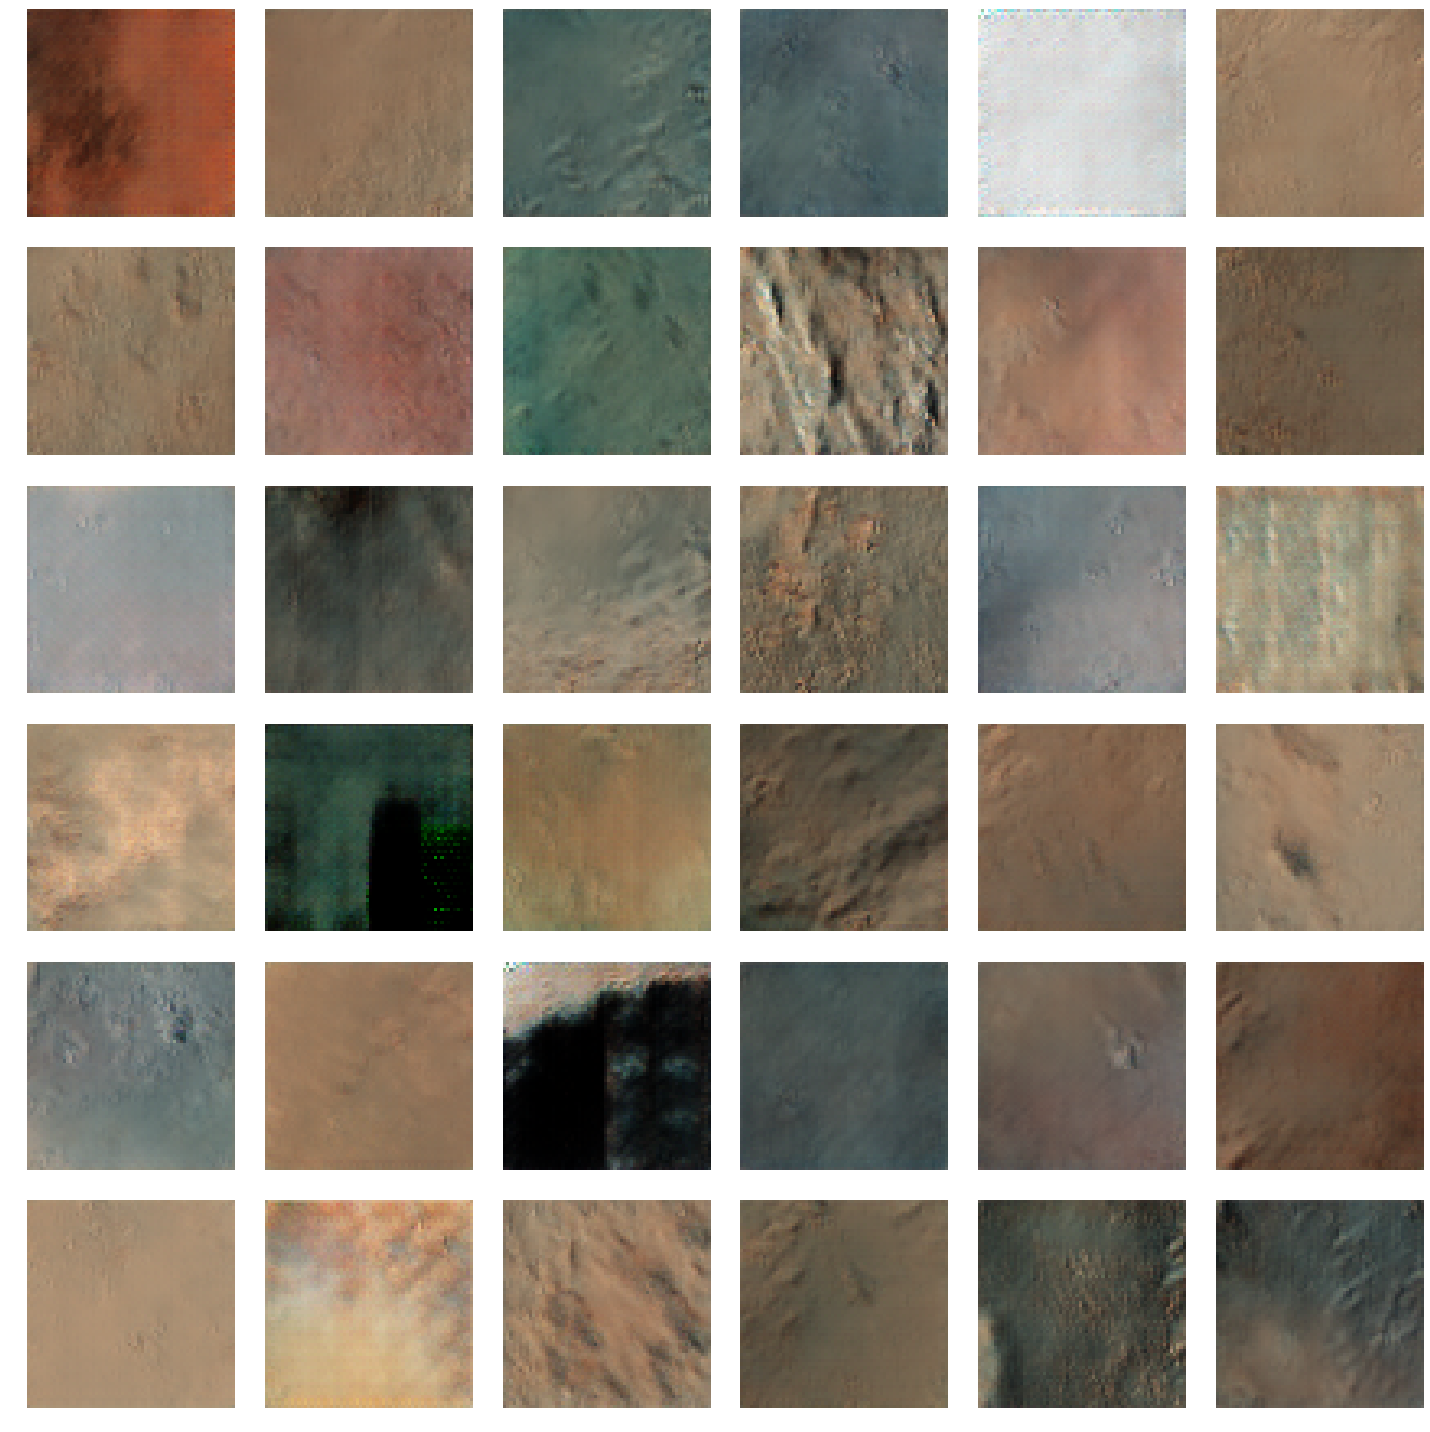

In [15]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=6, figsize=(20,20))

However the images leave much to be desired. There are still many artifacts in the image, and the resolution is small. Trying to train a deeper version of this type of GAN doesn't go well. To create higher quality images, we need a more sophistocated architecture and training protocol that allows for progressive growing.